# Evaluating RAG Systems with FloTorch

[FloTorch](https://www.flotorch.ai/) offers a robust evaluation framework for Retrieval-Augmented Generation (RAG) systems, enabling comprehensive assessment and comparison of Large Language Models (LLMs). It focuses on key metrics such as accuracy, cost, and latency, crucial for enterprise-level deployments.

## Key Evaluation Metrics for this Notebook

In this notebook, we will focus on evaluating our RAG pipelines using the following metrics:

* **Correctness:** This refers to the total number of samples that semantically both generated and expected are mateched

* **Inference Cost:** This refers to the total cost incurred for invoking Bedrock models to generate responses for all entries in the ground truth dataset.

* **Latency:** This measures the time taken for the inference process, specifically the duration of the Bedrock model invocations.


RAG systems are evaluated using a scoring method that measures response quality to questions in the evaluation set. Responses are rated as correct, Missing or incorrect:

- correct: The response correctly answers the user question and contains no hallucinated content.

- Missing: The answer does not provide the requested information. Such as “I don’t know”, “I’m sorry I can’t find …” or similar sentences without providing a concrete answer to the question.

- Incorrect: The response provides wrong or irrelevant information to answer the user question



### Load env variables

In [15]:
import json
with open("../Lab 1/variables.json", "r") as f:
    variables = json.load(f)

variables

{'accountNumber': '746074413210',
 'regionName': 'us-west-2',
 'collectionArn': 'arn:aws:aoss:us-west-2:746074413210:collection/3f35uv3lze9bdothrm0c',
 'collectionId': '3f35uv3lze9bdothrm0c',
 'vectorIndexName': 'ws-index-',
 'bedrockExecutionRoleArn': 'arn:aws:iam::746074413210:role/advanced-rag-workshop-bedrock_execution_role-us-west-2',
 's3Bucket': '746074413210-us-west-2-advanced-rag-workshop',
 'kbFixedChunk': 'WO4U6AWAU1',
 'kbSemanticChunk': 'OUFEWBGEES',
 'kbHierarchicalChunk': 'IHWIS6EP0H'}

### Evaluation Config

In [16]:
evaluation_config_data = {
   "eval_embedding_model" : "amazon.titan-embed-text-v2:0",
   "eval_retrieval_model" : "bedrock/cohere.command-r-v1:0",
   "eval_retrieval_service" : "bedrock",
   "aws_region" : variables['regionName'],
   "eval_embed_vector_dimension" : 1024
}

### Load RAG response data 

In [17]:
import json

filename = f"../results/ragas_evaluation_responses_for_different_models.json"

with open(filename, 'r', encoding='utf-8') as f:
    loaded_responses = json.load(f)


### Accuracy Evaluation with Custom Evaluation

In [18]:
from custom_evaluator import CustomEvaluator

In [19]:
evaluator = CustomEvaluator(evaluator_llm_info = evaluation_config_data)
evaluation_metrics = {}
for model_id, inference_data in loaded_responses.items():
    results = evaluator.evaluate(inference_data)
    evaluation_metrics[model_id] = results
    print(f"Evaluation completed for {model_id}")

Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.50s/it]


Evaluation completed for us.amazon.nova-micro-v1:0


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.40s/it]


Evaluation completed for us.amazon.nova-pro-v1:0


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.66s/it]


Evaluation completed for us.anthropic.claude-3-5-haiku-20241022-v1:0


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:45<00:00,  2.27s/it]

Evaluation completed for us.anthropic.claude-3-5-sonnet-20241022-v2:0


### Evaluation output

In [20]:
final_evaluation = evaluator.evaluate_results(evaluation_metrics)

### Cost and Latency Evaluation

In [21]:
from cost_compute_utils import calculate_cost_and_latency_metrics

for model in loaded_responses:
    inference_data = loaded_responses[model]
    cost_and_latency_metrics = calculate_cost_and_latency_metrics(inference_data, model,
                evaluation_config_data["aws_region"])
    custom_eval_metrics = final_evaluation[model].copy()
    if model not in final_evaluation:
        # Insert - key doesn't exist yet
        final_evaluation[model] = {**custom_eval_metrics, **cost_and_latency_metrics}
    else:
        # Update - key already exists
        merged = {**custom_eval_metrics, **cost_and_latency_metrics}
        final_evaluation[model].update(merged)

### Evaluation metrics as pandas df

In [22]:
import pandas as pd

# Convert the nested dictionary to a DataFrame
evaluation_df = pd.DataFrame.from_dict(final_evaluation, orient='index')

# If you want the kb_type as a column instead of an index
evaluation_df = evaluation_df.reset_index().rename(columns={'index': 'model'})

evaluation_df

,model,number of samples correct,inference_cost,average_inference_cost,latency,average_latency,processed_items
0,us.amazon.nova-micro-v1:0,17,0.003813,0.000191,19610.0,980.5,20
1,us.amazon.nova-pro-v1:0,20,0.085545,0.004277,23764.0,1188.2,20
2,us.anthropic.claude-3-5-haiku-20241022-v1:0,16,0.026591,0.001330,132016.0,6600.8,20
3,us.anthropic.claude-3-5-sonnet-20241022-v2:0,16,0.381432,0.019072,127302.0,6365.1,20


#### Apply plots for a given metrics

In [43]:
from plot_util import plot_column
import ipywidgets as widgets
from IPython.display import display

/Users/fl_lpt-301/Documents/flotorchnotebooks/lab4/sample-advanced-rag-using-bedrock-and-sagemaker/ravi/sample-advanced-rag-using-bedrock-and-sagemaker/Lab 4/plot_util.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


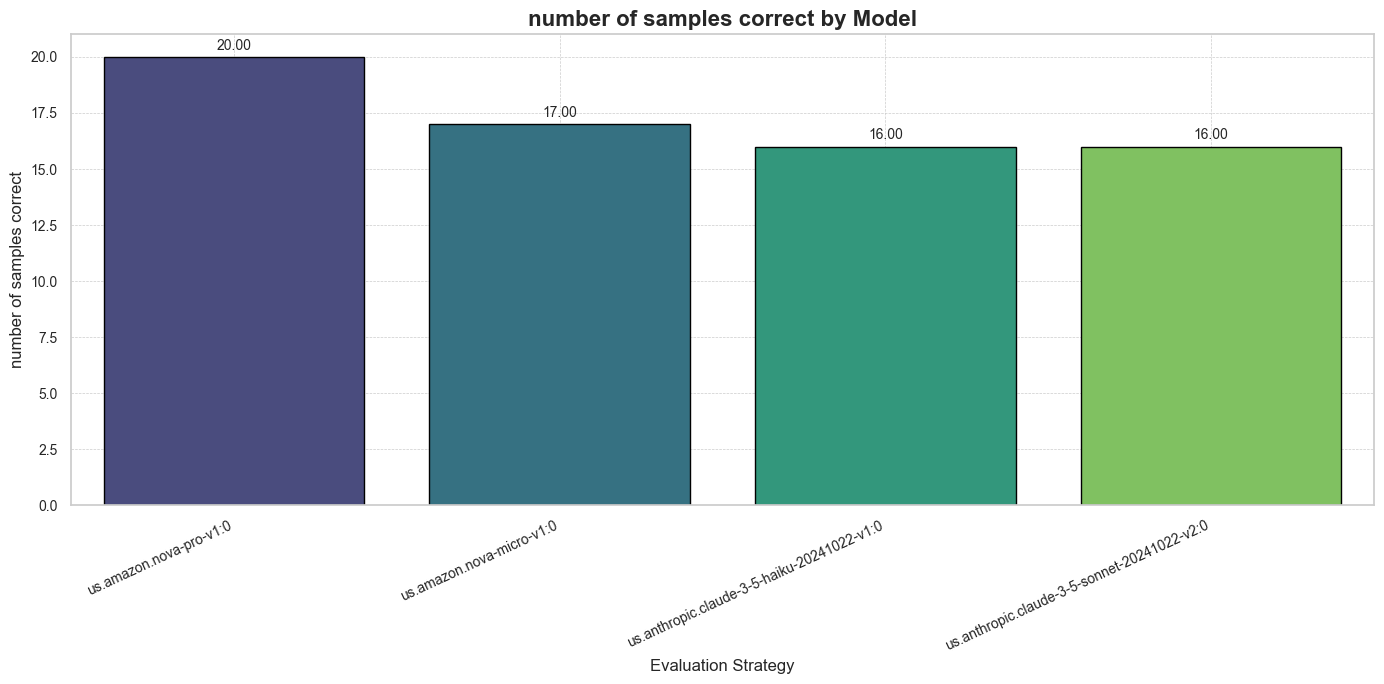

Dropdown(description='Metric:', layout=Layout(width='50%'), options=('number of samples correct', 'inference_c…

ToggleButtons(description='Plot Type:', options=('bar', 'line'), style=ToggleButtonsStyle(description_width='i…

Output()

In [44]:
# Dropdown widget
dropdown = widgets.Dropdown(
    options=[col for col in df.columns if col != 'model'],
    description='Metric:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Optional: Dropdown for plot kind (bar or line)
plot_kind = widgets.ToggleButtons(
    options=['bar', 'line'],
    description='Plot Type:',
    style={'description_width': 'initial'}
)

# Function to call on change
def update_plot(column, kind):
    plot_column(df, column, kind=kind)

# Link widgets to function
interactive_plot = widgets.interactive_output(update_plot, {
    'column': dropdown,
    'kind': plot_kind
})

# Display UI
display(dropdown, plot_kind, interactive_plot)